In [1]:
import sys
sys.path.append("../")
import urllib.request
from glob import glob

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.stats import binned_statistic
import pandas as pd
from tqdm import *
from astropy.cosmology import z_at_value
import astropy.units as u
from feynman import Diagram
from celluloid import Camera

from grf.units import *
from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.simulations import GaussianRandomFieldBoxes
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/smsharma/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Gaussian random field simulations for $\gamma \rightarrow A'$ transitions

In [2]:
# Plot parameters

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
# Where to save plots
plots_dir = "../paper/draft-letter/plots/"

## Simulations plot (Fig. 1)

In [4]:
# Load a power spectrum
pspec = PowerSpectrumGridInterpolator("nonlin_matter_bj")

In [8]:
# Create simulations

## Simulation properties

n_mc = 1
z_fid = 100.
z_range = [90.,110.]
k_max = 300.
n_points = 300
i_seed = 42

z_crossings_collect = []
P_collect = []

## Run simulations

for i_mc in tqdm_notebook(range(n_mc)):
    GRFB = GaussianRandomFieldBoxes(z_fid=z_fid, z_range=z_range, k_max=k_max, n_points=n_points, r_filter=1.5, log_pk_interp=pspec)
    GRFB.get_box_properties()
    GRFB.simulate_grf(seeds=np.arange(i_seed, i_seed + GRFB.n_boxes))
    GRFB.calculate_transition_prob()
    z_crossings_collect_temp = []
    P_collect_temp = []
    z_crossings_collect.append(GRFB.z_crossings_collect_temp)
    P_collect.append(GRFB.P_collect_temp)
    if GRFB.P_homo is not None:
        P_homo = GRFB.P_homo
    
P_collect = np.array(P_collect)
z_crossings_collect = np.array(z_crossings_collect)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: invalid value encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: divide by zero encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)


In [9]:
# Interpolate simulations from different boxes onto common grid

grid_new_list = []
old_space_list = []

for i in tqdm_notebook(range(len(GRFB.d_comoving_bins) - 1)):
    old_space = np.linspace(GRFB.d_comoving_bins[i], GRFB.d_comoving_bins[i + 1], np.shape(GRFB.fields[i][0])[0])
    old_space[0] += 1e-3 * np.random.rand(1)
    old_space = np.array([z_at_value(GRFB.cosmo.comoving_distance, old * u.Mpc) for old in old_space])
    old_space_list.append(old_space)
    new_space = np.linspace(GRFB.d_comoving_bins[i], GRFB.d_comoving_bins[i + 1], np.shape(GRFB.fields[-1][0])[0])
    new_space = np.array([z_at_value(GRFB.cosmo.comoving_distance, new * u.Mpc) for new in new_space])


    grid_new = RectBivariateSpline(old_space, old_space, GRFB.fields[i][0,:,:])(new_space, old_space)

    grid_new_list.append(grid_new)
    
old_space_all = (np.hstack(old_space_list))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [10]:
# Calculate analytic dP/dz curve

firas = FIRAS(pspec)

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


In [11]:
def make_plot(m_A=2):
    
    z_ary, dP_dz_ary, _, _  = firas.P_tot_perturb([firas.omega_FIRAS[0]], 1., m_A * 1e-13 * eV, pdf="gaussian", r_smooth=0.0314, k_max=100, n_z_bins=10000)
    dP_dz_ary = dP_dz_ary[0]
    
    ## Top plot, 2D simulation projection

    ax0 = plt.subplot(gs[0])

    im = ax0.imshow((np.hstack(grid_new_list[:])),
               cmap='twilight_shifted',
               vmin=0 + 0.5,
               vmax=2 - 0.5,
               extent=[GRFB.z_bins[0], GRFB.z_bins[-1], 0, GRFB.d_comoving_bins[-1] - GRFB.d_comoving_bins[-2]],
               aspect='auto',
               origin='lower'
              )

    ax0.text(108.2, 3.3, r"$m_{\gamma}/\overline{m_{\gamma}}$", fontsize=23)

#     ## Feynman diagram

#     axn = ax0.twinx()
#     diagram = Diagram(axn)
#     v1 = diagram.verticle(xy=(91., 0.5), marker='')
#     v2 = diagram.verticle(xy=(108., 0.5), marker='')
#     v3 = diagram.verticle(xy=(102., 0.5), marker='x', lw=0.8)

#     nwiggles = 50
#     wz1 = diagram.line(v1, v3, flavour='wiggly', nwiggles=int(nwiggles * 11 / 17))
#     wz1.scale(.2)
#     wz2 = diagram.line(v2, v3, style='wiggly', nwiggles=int(nwiggles * 6 / 17))
#     wz2.scale(.2)
#     wz1.text("$A^\prime$",fontsize=22, t=0.6, y=+0.1)
#     wz2.text("$\gamma$",fontsize=22, t=0.4, y=-0.1)

#     diagram.plot()

    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='4%', pad=0)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ## Middle plot, 1D simulation profile

    ax1 = plt.subplot(gs[1])

    ax1.plot(GRFB.z_ary_new, np.array(GRFB.m_A_perturb_ary) / (1e-13 * eV), alpha=0.4, c=cols_default[0], lw=1., label="Inhomogeneous plasma mass $m_{\gamma}$")
    ax1.plot(GRFB.z_ary_new, np.sqrt(GRFB.m_A_sq_ary) / (1e-13 * eV), ls='--', lw=1.5, c=cols_default[0], label="Homogeneous plasma mass $\overline{m_{\gamma}}$")

    ax1.plot()

    ax1.axhline(m_A, lw=1.5, c='lightgrey')

#     ax1.text(90.6, 3, r"$m_{A^\prime} = 2.95\times 10^{-13}$\,eV", fontsize=16)

#     ax1.legend(fontsize=16, loc='lower right')

    ## Bottom plot, analytic dP/dz and crossings in simulations

    ax2 = plt.subplot(gs[2])
    ax2.plot(z_ary, dP_dz_ary  / np.trapz(dP_dz_ary[(z_ary > 80) * (z_ary < 200)], z_ary[(z_ary > 80) * (z_ary < 200)]), lw=1.2, c=cols_default[1], label='Analytic crossing probability')
    ax2.fill_between(z_ary, np.zeros_like(z_ary), dP_dz_ary  / np.trapz(dP_dz_ary[(z_ary > 80) * (z_ary < 200)], z_ary[(z_ary > 80) * (z_ary < 200)]), alpha=0.1, color=cols_default[1])

    zero_crossings = np.where(np.diff(np.sign(np.array(GRFB.m_A_perturb_ary) / (1e-13 * eV) - m_A)))[0]
    z_crossings = np.take(GRFB.z_ary_new, np.array(zero_crossings))

    for z_cross in z_crossings:
        ax2.axvline(z_cross, lw=1, alpha=0.2, c=cols_default[0])

#     ax2.plot([],[], lw=1, alpha=0.2, c=cols_default[0], label='Crossings in simulation')
#     ax2.legend(fontsize=16, )

    ## Set plot properties

    ax0.set_ylabel("$D_{\mathrm c}$\,[Mpc]", labelpad=25)
    ax1.set_ylabel("$m_{\gamma}\,[10^{-13}\,\mathrm{eV]}$")
    ax2.set_ylabel(r"$\mathrm d\langle P_{\gamma \rightarrow A'} \rangle / \mathrm dz$")
    ax2.set_xlabel("$z$", fontsize=22)

    plt.suptitle(r"\bf{Perturbations in the Photon Plasma Mass}", y=0.95, fontsize=22)

    ax0.set_xlim(min(GRFB.z_ary_new), max(GRFB.z_ary_new))
    ax1.set_xlim(min(GRFB.z_ary_new), max(GRFB.z_ary_new))
    ax2.set_xlim(min(GRFB.z_ary_new), max(GRFB.z_ary_new))
    ax2.set_ylim(0, .2)

    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)

    loc_major = matplotlib.ticker.MultipleLocator(base=1.) # this locator puts ticks at regular intervals
    loc_minor = matplotlib.ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax1.xaxis.set_major_locator(loc_major)
    ax2.xaxis.set_major_locator(loc_major)
    ax2.xaxis.set_minor_locator(loc_minor)
    ax2.xaxis.set_minor_locator(loc_minor)

    ax2.set(xticks=np.arange(90, 110), xticklabels=[x if not x%2 else None for x in np.arange(90, 110)])

    plt.subplots_adjust(wspace=10)

    plt.tight_layout()

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be creat

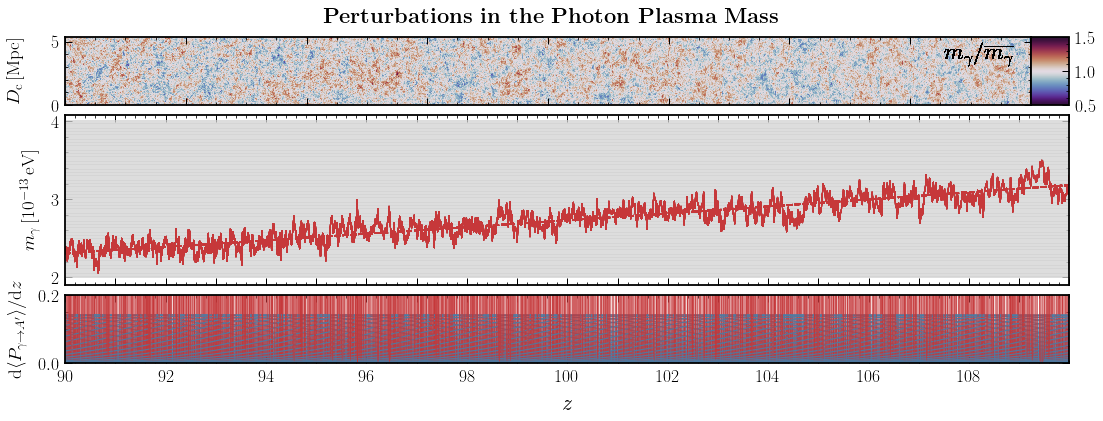

In [12]:
# Make plot!

fig = plt.figure(figsize=(18, 6)) 

## Define gridspec
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2.5, 1], hspace=0.1) 

cam = Camera(fig)

m_A_ary = np.linspace(2, 4, 100)

for m_A in tqdm_notebook(m_A_ary):

    make_plot(m_A)
    cam.snap()

In [14]:
anim = cam.animate()

In [15]:
anim.save('./plots_for_talk//animation_sim.gif', writer='imagemagick', fps=12)

In [37]:
anim.save('/Users/smsharma/Desktop/animation_sim.mp4', fps=12., dpi=100)

In [78]:
# n_mc = 100
# z_fid = 20.
# z_range = [18.,22.]
# k_max = 10.
# n_points = 100

# z_crossings_collect = []
# P_collect = []

# for i_mc in tqdm_notebook(range(n_mc)):
#     GRFB = GaussianRandomFieldBoxes(z_fid=z_fid, z_range=z_range, k_max=k_max, n_points=n_points, r_filter=2., use_nbodykit=1, generate_1d=0, log_pk_interp=pspec)
#     z_crossings_collect_temp = []
#     P_collect_temp = []
#     z_crossings_collect.append(GRFB.z_crossings_collect_temp)
#     P_collect.append(GRFB.P_collect_temp)
#     if GRFB.P_homo is not None:
#         P_homo = GRFB.P_homo
    
# P_collect = np.array(P_collect)
# z_crossings_collect = np.array(z_crossings_collect)